# Generation and post-analysis in aids dataset

In [118]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [119]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [120]:
%matplotlib inline

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

### Experiment setting - links to data

In [121]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

## Statistical analysis with original data

In [122]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,27.000000,0,1,1,1,0,100,169.0,39.0,34
1,41.000000,0,1,2,2,0,90,149.5,15.0,34
2,28.428571,0,1,1,1,0,90,46.0,53.0,48
3,38.571429,0,1,1,2,0,100,54.5,6.0,51
4,39.428571,0,1,1,1,0,100,95.0,7.0,34


In [123]:
aids_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')

In [124]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]

In [125]:
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
aids_control_columns

['time',
 'censor',
 'strat2',
 'sex',
 'raceth',
 'ivdrug',
 'karnof',
 'cd4',
 'priorzdv',
 'age']

### Data loading and Feature analysis treated/control

In [126]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [127]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [128]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [129]:
df_transformed_all.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age', 'treatment'],
      dtype='object')

In [130]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,27.000000,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,41.000000,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,28.428572,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,38.571430,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,39.428570,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


In [131]:
df_transformed_all.shape

(1151, 11)

In [132]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 10


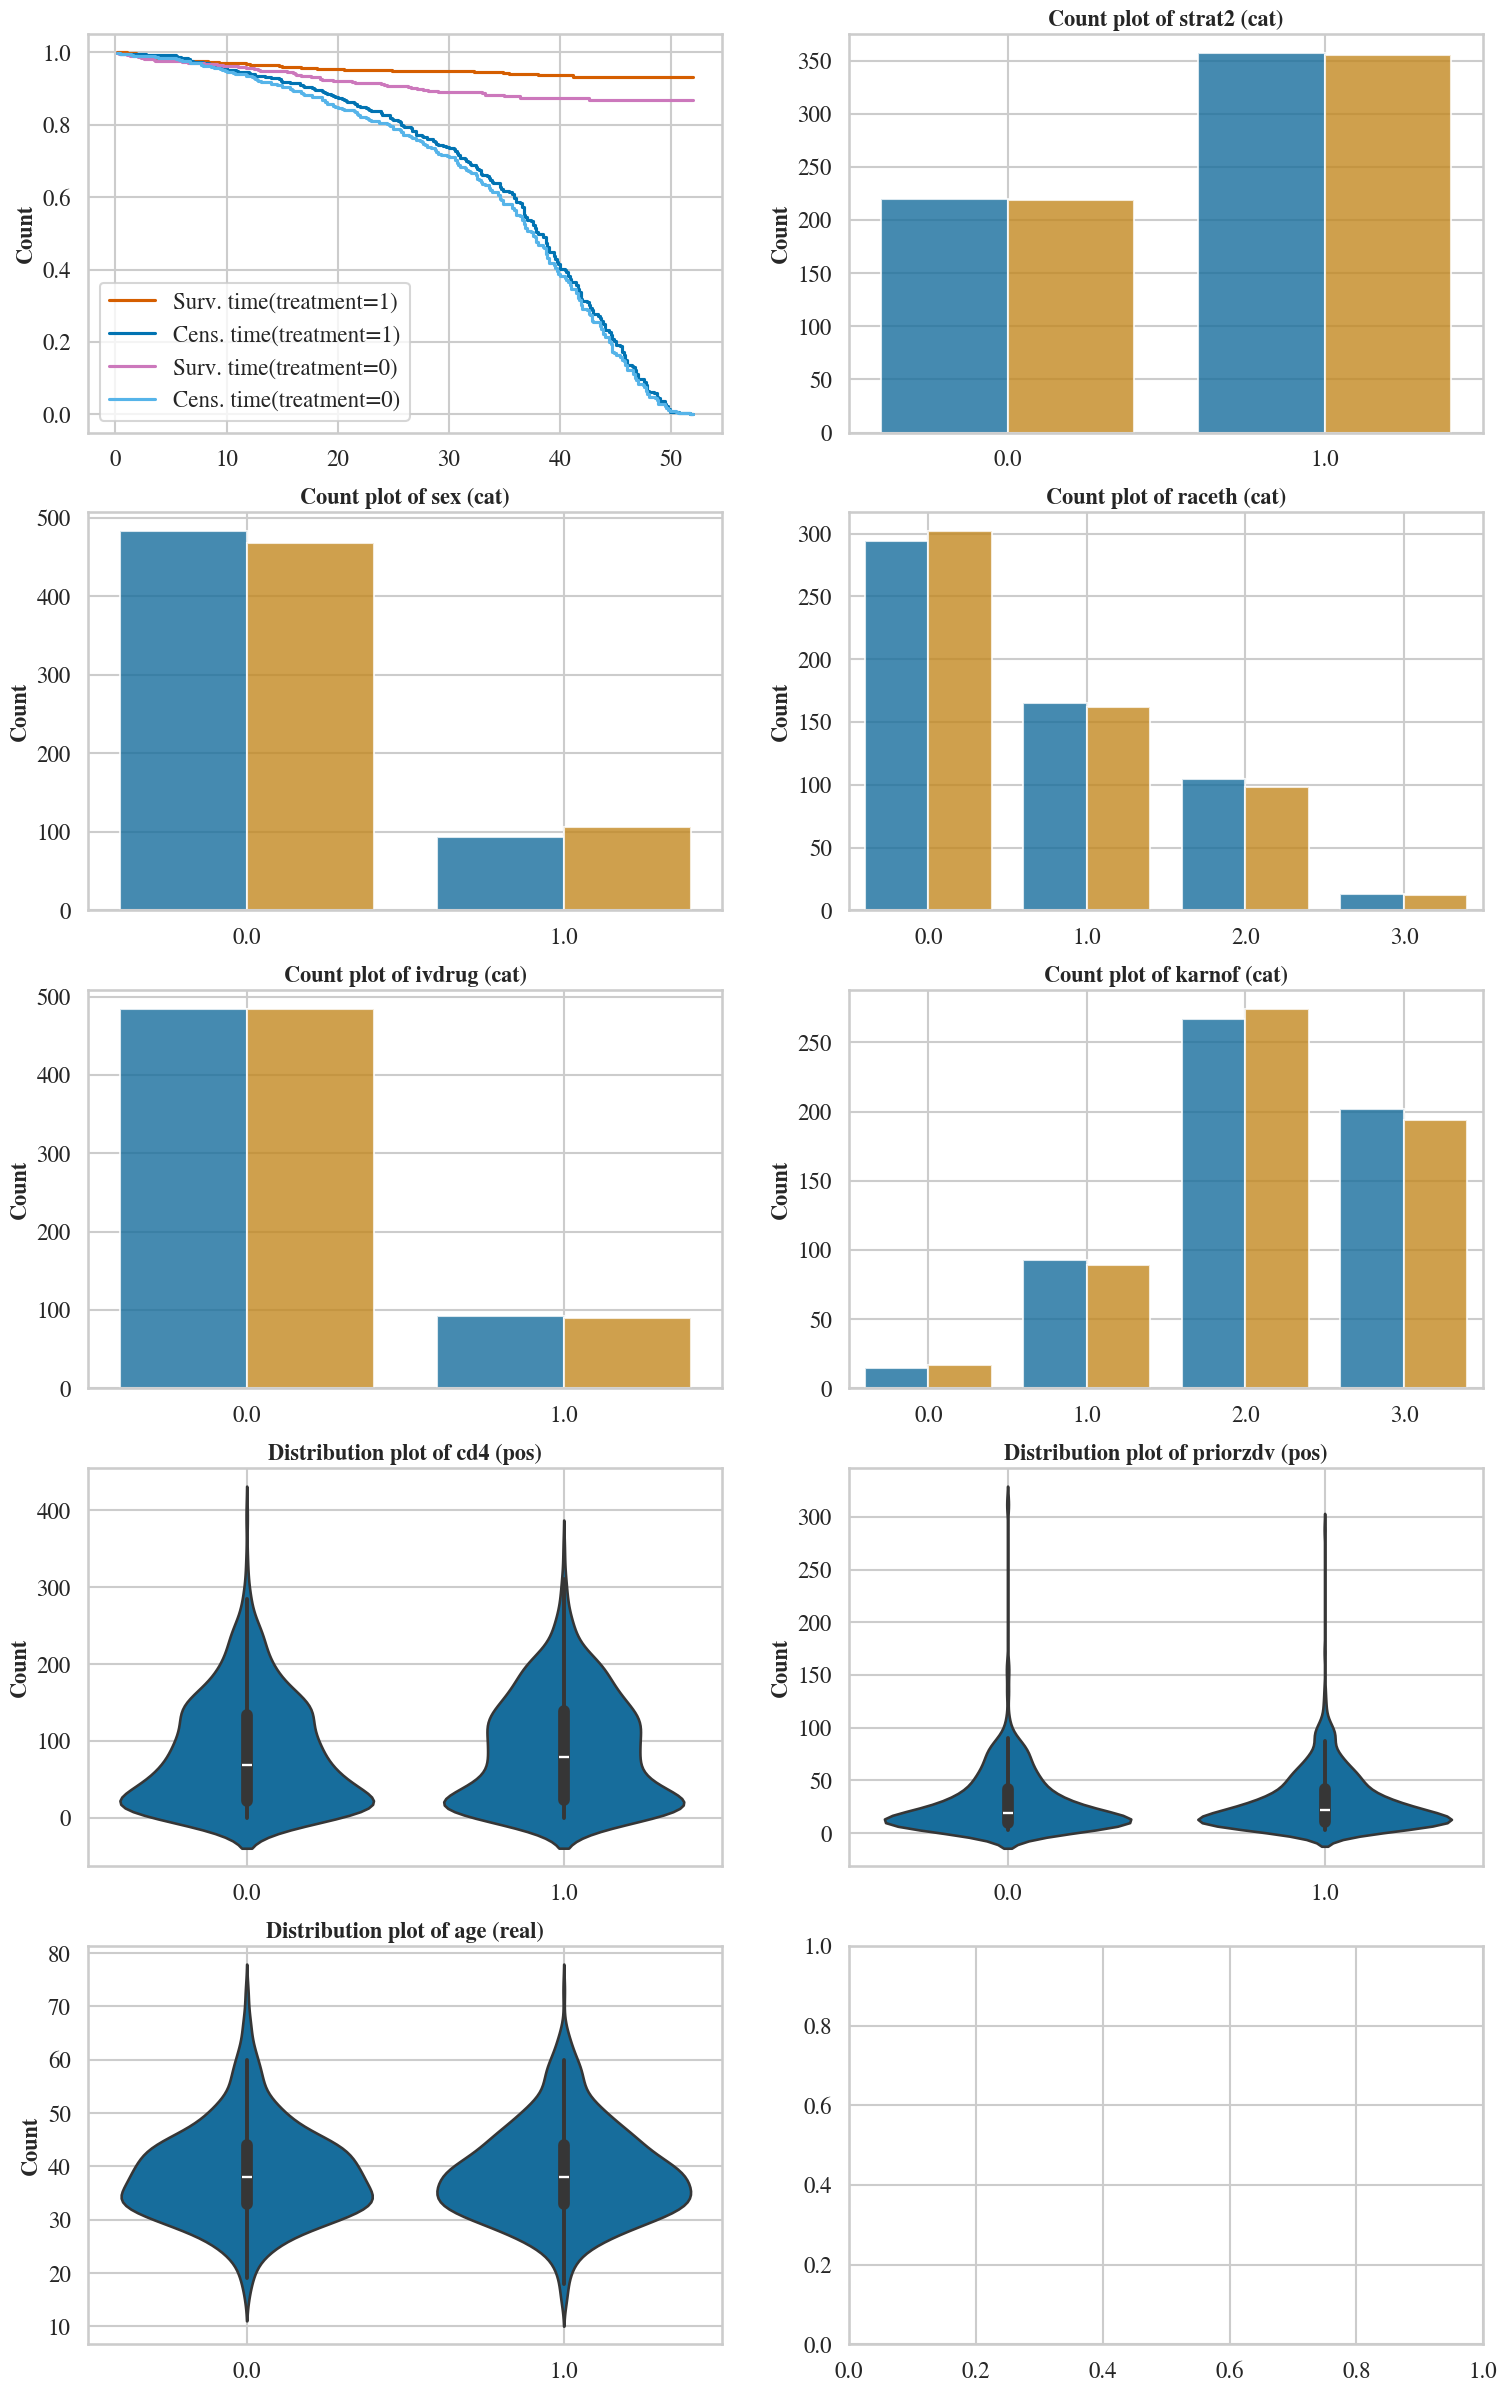

In [133]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [134]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [135]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                 
                                          Missing            Overall                  0                  1 P-Value
n                                                               1151                577                574        
time, median [Q1,Q3]                            0   36.7 [24.9,42.9]   35.9 [22.6,42.6]   37.6 [26.7,43.6]   0.014
censor, n (%)            0.0                             1055 (91.7)         514 (89.1)         541 (94.3)   0.002
                         1.0                                96 (8.3)          63 (10.9)           33 (5.7)        
strat2, n (%)            0.0                              439 (38.1)         220 (38.1)         219 (38.2)   1.000
                         1.0                              712 (61.9)         357 (61.9)         355 (61.8)        
sex, n (%)               0.0                              951 (82.6)         483

## Training VAE

### Experiment setting

In [136]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [137]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1500
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [138]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_loglog', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.1074, ELBO_train: -21.25485992, KL_z: 1.42278559, KL_s: 0.09737287, reconstruction loss: -19.73470147
Epoch: [100]  time: 3.1967, ELBO_train: -17.70240517, KL_z: 0.66249825, KL_s: 0.03413038, reconstruction loss: -17.00577654
Epoch: [200]  time: 6.0884, ELBO_train: -17.64858551, KL_z: 0.79646262, KL_s: 0.03369064, reconstruction loss: -16.81843225
Epoch: [300]  time: 8.9104, ELBO_train: -17.56677742, KL_z: 0.96173592, KL_s: 0.03828897, reconstruction loss: -16.56675253
Epoch: [400]  time: 11.6995, ELBO_train: -17.40917969, KL_z: 1.10424540, KL_s: 0.03523159, reconstruction loss: -16.26970270
Epoch: [500]  time: 14.4988, ELBO_train: -17.43875465, KL_z: 1.22810767, KL_s: 0.03647861, reconstruction loss: -16.17416837
Epoch: [600]  time: 17.3293, ELBO_train: -17.37950859, KL_z: 1.26805930, KL_s: 0.03861494, reconstruction loss: -16.07283435
Epoch: [700]  time: 20.0920, ELBO_train: -17.35793800, KL_z: 1.31983578, KL_s: 0.03853774, reconstruction loss: -15.99956448
Epoch

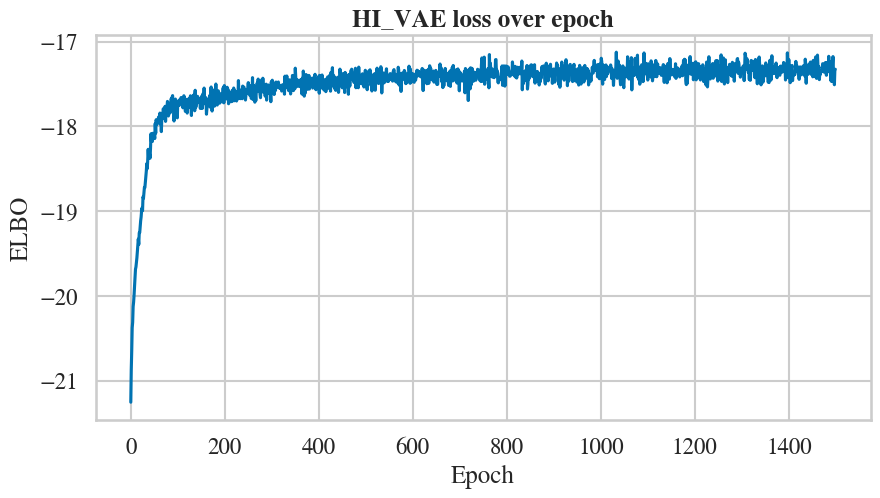

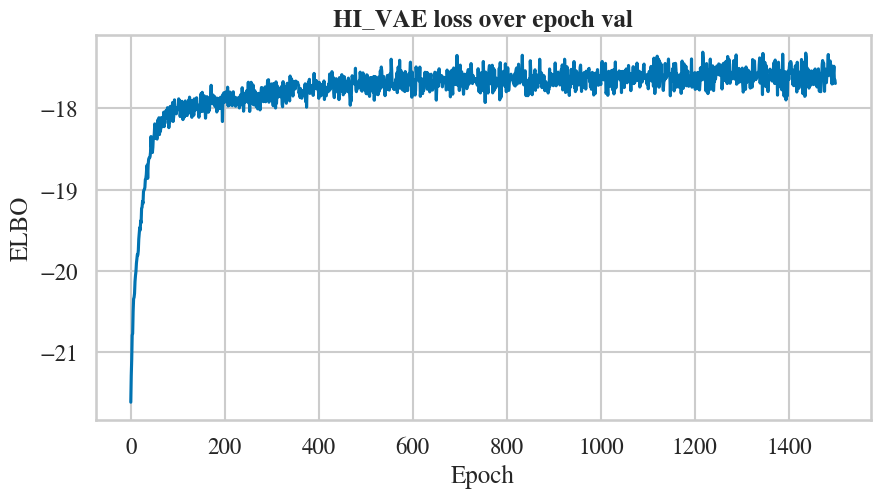

In [139]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [140]:
#visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
#                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

## Generated samples from control dataset

In [141]:
data.shape

torch.Size([577, 19])

In [142]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [143]:
miss_mask_forgen.shape

torch.Size([577, 9])

In [144]:
data_forgen.shape

torch.Size([577, 19])

#### Generate from original sample

In [145]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 100

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

577


### Statistical analysis with simulated vs initial control data

In [146]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [147]:
df_transformed_generated

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,sample
0,6.566725,0.0,1.0,0.0,1.0,0.0,3.0,784.000000,10.990608,34.525719,0
1,19.355486,0.0,1.0,1.0,0.0,0.0,1.0,71.728912,6.488655,34.858097,0
2,33.741081,1.0,1.0,0.0,1.0,0.0,3.0,22.555012,7.805899,35.720184,0
3,37.070301,0.0,1.0,0.0,1.0,0.0,3.0,30.271807,10.776630,43.555206,0
4,48.576286,0.0,1.0,0.0,0.0,0.0,2.0,457.685638,6.073932,45.297348,0
...,...,...,...,...,...,...,...,...,...,...,...
572,1.663436,1.0,1.0,0.0,0.0,0.0,3.0,63.828781,11.488737,39.122120,0
573,28.912058,0.0,0.0,0.0,0.0,0.0,1.0,29.829079,30.972574,27.090015,0
574,28.696754,0.0,0.0,1.0,1.0,0.0,3.0,6.178215,10.925940,39.713074,0
575,40.474575,0.0,1.0,0.0,0.0,1.0,1.0,46.712566,31.202780,36.480350,0


comparison variable sample 10


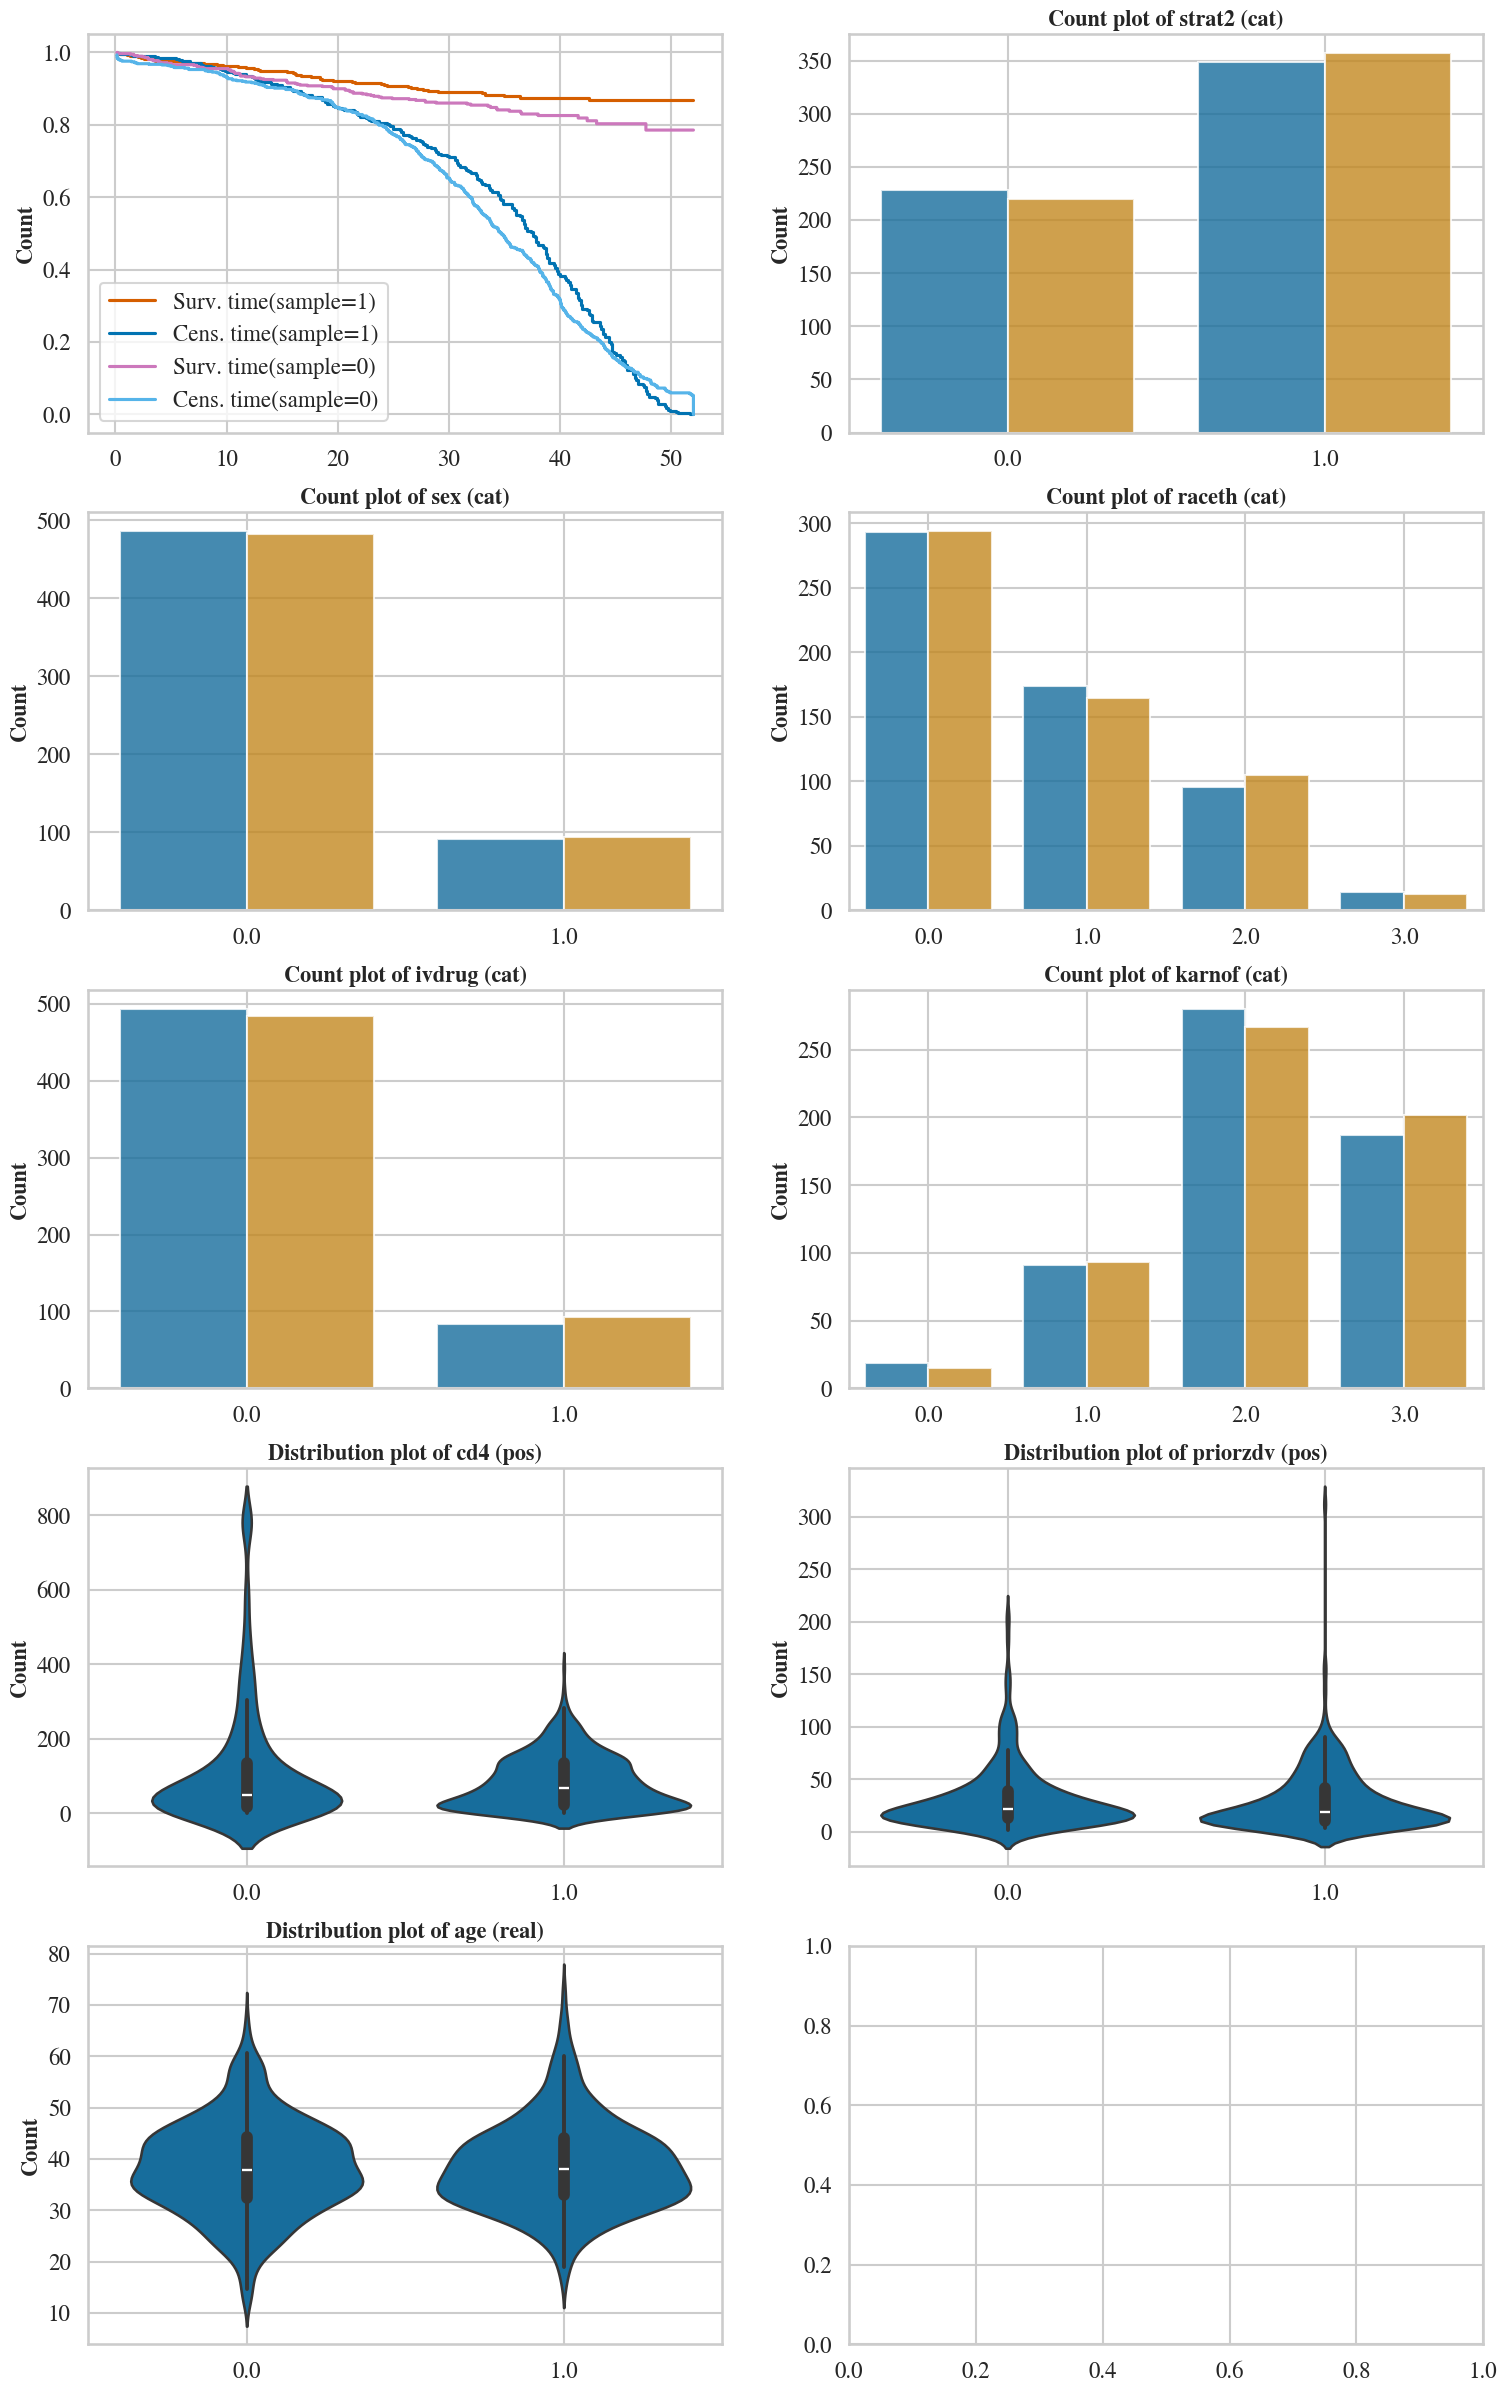

In [148]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [149]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [150]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                 
                                       Missing            Overall                  0                  1 P-Value
n                                                            1154                577                577        
time, median [Q1,Q3]                         0   33.7 [21.7,41.6]   32.2 [21.0,40.1]   35.9 [22.6,42.6]   0.004
censor, n (%)            0.0                          1005 (87.1)         491 (85.1)         514 (89.1)   0.053
                         1.0                           149 (12.9)          86 (14.9)          63 (10.9)        
strat2, n (%)            0.0                           448 (38.8)         228 (39.5)         220 (38.1)   0.672
                         1.0                           706 (61.2)         349 (60.5)         357 (61.9)        
sex, n (%)               0.0                           969 (84.0)         486 (84.2)         483 (83.7) 

In [151]:
test_equality_survival = np.zeros((n_generated_sample,2))
for i in np.arange(n_generated_sample):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_initial["sample"]=1
    df_transformed_generated["sample"]=0
    df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)
    
    Y_T = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==1,df_transformed_initial_generated.to_numpy()[:,0])
    Y_C = Surv.from_arrays(df_transformed_initial_generated.to_numpy()[:,1]==0,df_transformed_initial_generated.to_numpy()[:,0])
    test_equality_survival[i,0] = compare_survival(Y_T,df_transformed_initial_generated.to_numpy()[:,-1])[1]
    test_equality_survival[i,1] = compare_survival(Y_C,df_transformed_initial_generated.to_numpy()[:,-1])[1]



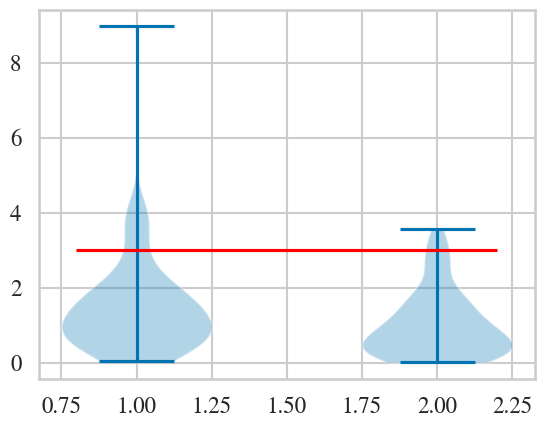

In [152]:
plt.violinplot(-np.log(test_equality_survival))
plt.hlines(-np.log(0.05),0.8,2.2,color='red')

### Statistical analysis: generated control x initial treated

In [153]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=aids_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [154]:
#df_transformed_all.head()

In [155]:
#categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
#continuous = ['time', 'cd4',   'priorzdv', 'age']
#nonnormal = ['time', 'cd4',   'priorzdv']
#table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
#print(table1)

In [156]:
#table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
#print(table1)

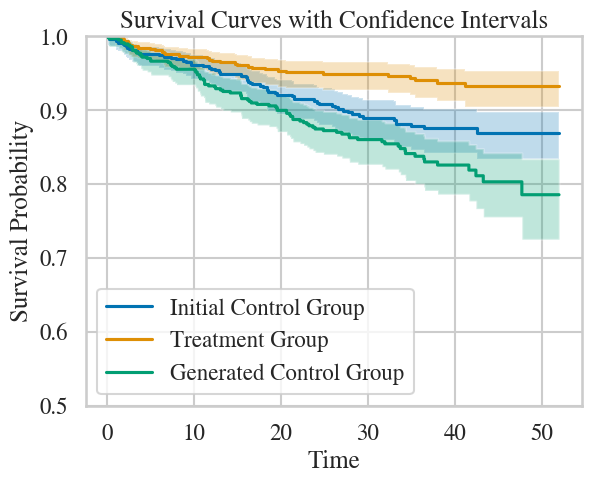

In [157]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(.50, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [158]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']

Initial Cox model

In [196]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,27.000000,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,41.000000,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,28.428572,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,38.571430,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,39.428570,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


In [197]:
df_transformed_all = df_transformed_all.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'])
df_transformed_all_oh = df_transformed_all.copy()

for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)


X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [198]:
df_transformed_all_oh

,time,censor,treatment,strat2,sex,ivdrug,cd4,priorzdv,age,raceth1.0,raceth2.0,raceth3.0,karnof1.0,karnof2.0,karnof3.0
0,27.000000,0.0,0,1.0,0.0,0.0,169.0,39.0,34.0,False,False,False,False,False,True
1,41.000000,0.0,0,1.0,1.0,0.0,149.5,15.0,34.0,True,False,False,False,True,False
2,28.428572,0.0,0,1.0,0.0,0.0,46.0,53.0,48.0,False,False,False,False,True,False
3,38.571430,0.0,0,1.0,0.0,0.0,54.5,6.0,51.0,True,False,False,False,False,True
4,39.428570,0.0,0,1.0,0.0,0.0,95.0,7.0,34.0,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,7.000000,0.0,1,1.0,0.0,0.0,258.5,10.0,45.0,False,False,False,False,False,False
1147,48.714287,0.0,1,0.0,0.0,0.0,18.5,8.0,52.0,True,False,False,False,True,False
1148,39.000000,0.0,1,1.0,0.0,0.0,65.5,103.0,44.0,False,False,False,False,False,True
1149,6.714286,1.0,1,0.0,0.0,0.0,7.5,20.0,41.0,True,False,False,True,False,False


In [199]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-6.66311702e-01, -1.51111787e-02,  2.03117243e-01, -5.55172796e-01,
       -1.46215358e-02, -7.93512048e-04,  2.40314802e-02, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

Tests in all generated datasets

In [200]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0]))
LR = np.zeros(n_generated_sample)
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen = df_transformed_T_Cgen.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'])
    filename = "./dataset/" + dataset_name + "/generated" + str(i) + ".csv"
    df_transformed_T_Cgen.to_csv(filename,index = False)
    number_column_treatment = 0 # in X_initial
    
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    LR[i] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,:] = cox_generated.coef_[:]


In [201]:

df_transformed_T_Cgen_oh



,time,censor,treatment,strat2,sex,ivdrug,cd4,priorzdv,age,raceth1.0,raceth2.0,raceth3.0,karnof1.0,karnof2.0,karnof3.0
0,34.571430,0.0,1,0.0,0.0,0.0,23.500000,9.000000,20.000000,False,False,False,False,False,True
1,40.857143,0.0,1,0.0,0.0,1.0,10.000000,12.000000,46.000000,False,False,False,False,True,False
2,40.714287,0.0,1,0.0,0.0,0.0,0.000000,24.000000,51.000000,False,False,False,False,False,False
3,40.714287,0.0,1,1.0,0.0,1.0,117.500000,24.000000,40.000000,True,False,False,True,False,False
4,47.714287,0.0,1,0.0,1.0,0.0,7.500000,62.000000,38.000000,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,19.494593,0.0,0,1.0,0.0,0.0,360.529144,9.164237,29.211819,False,False,False,False,False,True
1147,30.362793,0.0,0,0.0,0.0,0.0,87.693672,83.307671,24.672569,True,False,False,False,True,False
1148,29.702328,0.0,0,0.0,0.0,0.0,6.803935,12.749204,37.100361,False,False,False,False,True,False
1149,37.274395,0.0,0,1.0,0.0,0.0,76.902275,65.812798,40.031601,False,True,False,True,False,False


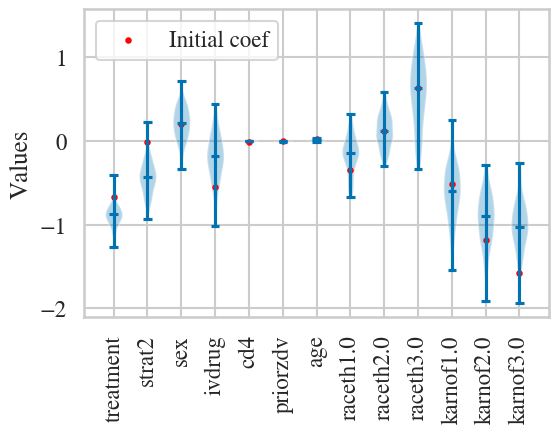

In [202]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins

#y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(df_transformed_T_Cgen_oh.columns[2:])
ax.set_ylabel("Values")
ax.legend()

plt.show()

### Log rank test

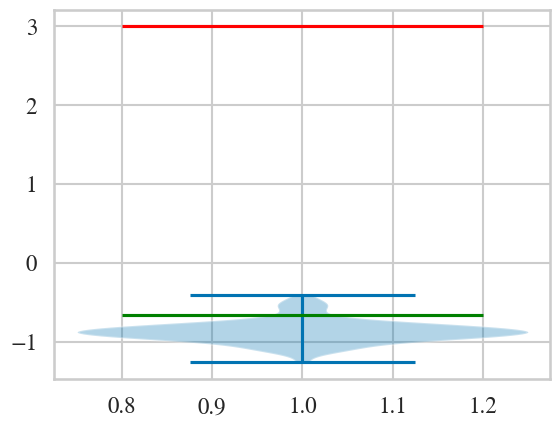

In [203]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

In [204]:
np.mean(coef_treat[:,0] >= -np.log(0.05))

0.0

### Test coefficient traitement (Cox)

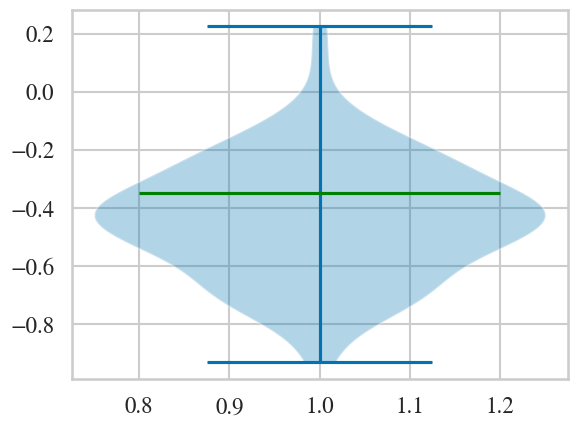

In [205]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

## Stratified w.r. CD4 count analysis

In [219]:
df_transformed_all

,time,censor,treatment,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,27.000000,0.0,0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0
1,41.000000,0.0,0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0
2,28.428572,0.0,0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0
3,38.571430,0.0,0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0
4,39.428570,0.0,0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...
1146,7.000000,0.0,1,1.0,0.0,0.0,0.0,0.0,258.5,10.0,45.0
1147,48.714287,0.0,1,0.0,0.0,1.0,0.0,2.0,18.5,8.0,52.0
1148,39.000000,0.0,1,1.0,0.0,0.0,0.0,3.0,65.5,103.0,44.0
1149,6.714286,1.0,1,0.0,0.0,1.0,0.0,1.0,7.5,20.0,41.0


In [220]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [224]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'treatment', 'strat2', 'sex', 'ivdrug', 'cd4',
       'priorzdv', 'age', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

In [225]:
cd4_threshold = 50
df_transformed_all_oh_lowcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] <= cd4_threshold]
print(df_transformed_all_oh_lowcd4.shape)
X_initial_lowcd4 = df_transformed_all_oh_lowcd4.to_numpy()[:,2:15]
Y_initial_lowcd4 = Surv.from_arrays(df_transformed_all_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_all_oh_lowcd4.to_numpy()[:,0]) 
df_transformed_all_oh_highcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] > cd4_threshold]
print(df_transformed_all_oh_highcd4.shape)
X_initial_highcd4 = df_transformed_all_oh_highcd4.to_numpy()[:,2:15]
Y_initial_highcd4 = Surv.from_arrays(df_transformed_all_oh_highcd4.to_numpy()[:,1]==1,df_transformed_all_oh_highcd4.to_numpy()[:,0]) 

(459, 15)
(692, 15)


In [226]:
cox_initial_lowcd4 = CoxPHSurvivalAnalysis()
cox_initial_lowcd4.fit(X_initial_lowcd4,Y_initial_lowcd4)
cox_initial_highcd4 = CoxPHSurvivalAnalysis()
cox_initial_highcd4.fit(X_initial_highcd4,Y_initial_highcd4)


CoxPHSurvivalAnalysis()

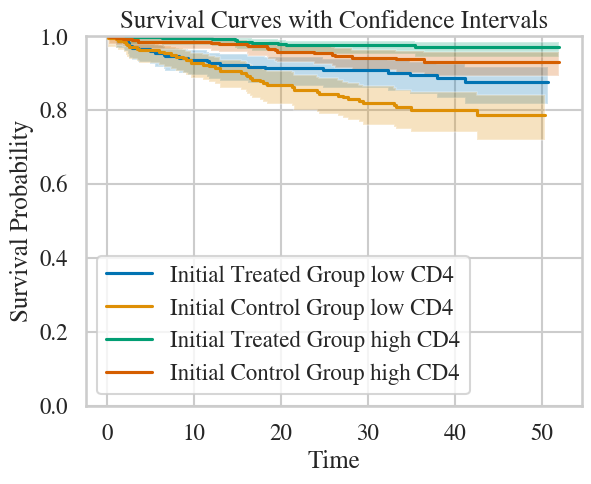

In [213]:
time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, conf_int_initial_lowcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, conf_int_initial_lowcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_highcd4_T, survival_prob_initial_highcd4_T, conf_int_initial_highcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


time_initial_highcd4_C, survival_prob_initial_highcd4_C, conf_int_initial_highcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

plt.step(time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, where="post", label="Initial Treated Group low CD4")
plt.fill_between(time_initial_lowcd4_T, conf_int_initial_lowcd4_T[0], conf_int_initial_lowcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, where="post", label="Initial Control Group low CD4")
plt.fill_between(time_initial_lowcd4_C, conf_int_initial_lowcd4_C[0], conf_int_initial_lowcd4_C[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_T, survival_prob_initial_highcd4_T, where="post", label="Initial Treated Group high CD4")
plt.fill_between(time_initial_highcd4_T, conf_int_initial_highcd4_T[0], conf_int_initial_highcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_C, survival_prob_initial_highcd4_C, where="post", label="Initial Control Group high CD4")
plt.fill_between(time_initial_highcd4_C, conf_int_initial_highcd4_C[0], conf_int_initial_highcd4_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

In [227]:
compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])

(5.535873093721627, 0.018630467405504756)

In [228]:
compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])

(4.395519026726351, 0.03603349014270788)

In [229]:
coef_treat_lowcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
coef_treat_highcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen = df_transformed_T_Cgen.reindex(columns=['time', 'censor' , 'treatment','strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'])
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    df_transformed_T_Cgen_oh_lowcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] <= cd4_threshold]
    X_gen_lowcd4 = df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,2:15]
    Y_gen_lowcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,0]) 
    df_transformed_T_Cgen_oh_highcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] > cd4_threshold]
    X_gen_highcd4 = df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,2:15]
    Y_gen_highcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,0]) 
    
    coef_treat_lowcd4[i,0] = -np.log(compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])[1])
    cox_generated_lowcd4 = CoxPHSurvivalAnalysis()
    cox_generated_lowcd4.fit(X_gen_lowcd4,Y_gen_lowcd4)
    coef_treat_lowcd4[i,1:] = cox_generated_lowcd4.coef_[:]

    coef_treat_highcd4[i,0] = -np.log(compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])[1])
    cox_generated_highcd4 = CoxPHSurvivalAnalysis()
    cox_generated_highcd4.fit(X_gen_highcd4,Y_gen_highcd4)
    coef_treat_highcd4[i,1:] = cox_generated_highcd4.coef_[:]


In [232]:
df_transformed_T_Cgen_oh_lowcd4.columns[2:]

Index(['treatment', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0', 'karnof2.0',
       'karnof3.0'],
      dtype='object')

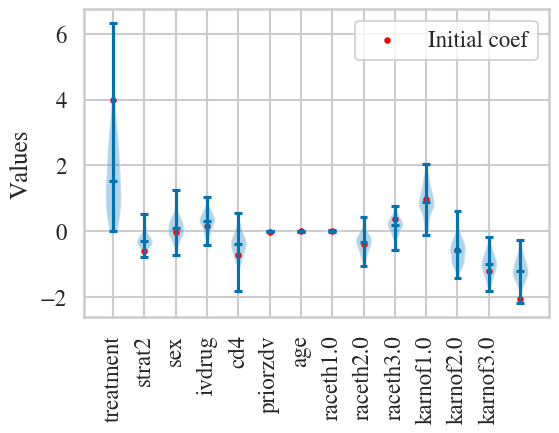

In [233]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_lowcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_lowcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_lowcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_lowcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(df_transformed_T_Cgen_oh_lowcd4.columns[2:])
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [234]:
compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])

(3.7426977544122155, 0.053038746373934006)

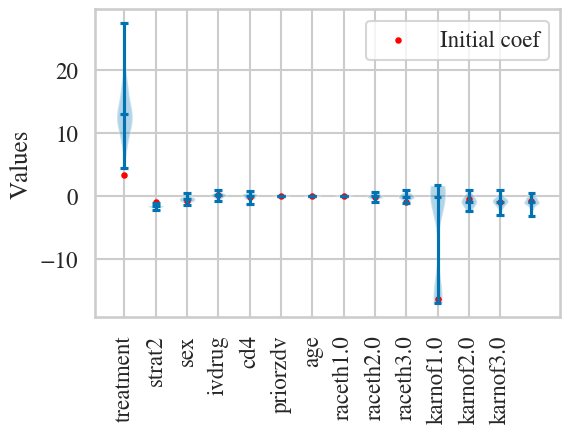

In [235]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_highcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_highcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_highcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_highcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(df_transformed_T_Cgen_oh_lowcd4.columns[2:])
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [236]:

compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])

(18.459086747788028, 1.7359114593929175e-05)

{'joint': 0.04426478221545271}